# Genetic Algorithm + Backpropagation for IPC Forecasting

In [2]:
!pip install pandas numpy scikit-learn deap matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.3 MB/s eta 0:00:00


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from deap import base, creator, tools, algorithms
import random
from functools import partial

df = pd.read_csv("macro_data.csv")


In [4]:

def create_lag_features(df, lags):
    df_lagged = pd.DataFrame()
    for col, lag in lags.items():
        df_lagged[f"{col}(lag)"] = df[col].shift(lag)
    df_lagged["IPC(+1)"] = df["IPC"].shift(-1)
    df_lagged.dropna(inplace=True)
    return df_lagged.reset_index(drop=True)

lags = {"IOC": 0, "IPC": 0, "KVVE": 7, "M0": 7, "M2": 7}
data = create_lag_features(df, lags)
data.head()


,IOC(lag),IPC(lag),KVVE(lag),M0(lag),M2(lag),IPC(+1)
0,103.006153,103.624578,29292.314629,15075.147855,40357.787360,102.795832
1,103.458359,102.795832,30197.840604,15308.016096,40968.947792,104.216029
2,106.167120,104.216029,30644.969272,15204.155849,41899.377774,103.618215
3,102.659866,103.618215,30823.351161,15681.921007,42278.291848,104.024066
4,103.652748,104.024066,31552.010205,15904.248273,40254.983693,105.139921


## Training models in windowed mode

In [6]:
results = []
true_vals = []
pred_vals = []

# Avoiding re-creating types
if "FitnessMin" not in creator.__dict__:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMin)

for i in range(10):
    window = data.iloc[i:i+12]
    X = window.drop("IPC(+1)", axis=1).values
    y = window["IPC(+1)"].values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    mlp = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', max_iter=1, warm_start=True)
    mlp.fit(X_scaled, y_scaled)

    n_weights = sum(w.size for w in mlp.coefs_ + mlp.intercepts_)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", lambda: random.uniform(-1.0, 1.0))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_weights)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def eval_nn(individual):
        start = 0
        i_weights = []
        for coef in mlp.coefs_ + mlp.intercepts_:
            shape = coef.shape
            size = np.prod(shape)
            new_weights = np.array(individual[start:start + size]).reshape(shape)
            i_weights.append(new_weights)
            start += size
        mlp.coefs_ = i_weights[:len(mlp.coefs_)]
        mlp.intercepts_ = i_weights[len(mlp.coefs_):]
        y_pred = mlp.predict(X_scaled)
        return (mean_squared_error(y_scaled, y_pred),)

    toolbox.register("evaluate", eval_nn)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=20)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=20, halloffame=hof, verbose=False)

    # Assigning the best weights manually
    start = 0
    i_weights = []
    for coef in mlp.coefs_ + mlp.intercepts_:
        shape = coef.shape
        size = np.prod(shape)
        new_weights = np.array(hof[0][start:start + size]).reshape(shape)
        i_weights.append(new_weights)
        start += size

    mlp.coefs_ = i_weights[:len(mlp.coefs_)]
    mlp.intercepts_ = i_weights[len(mlp.coefs_):]

    y_pred_scaled = mlp.predict(X_scaled)
    y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    mse_real = mean_squared_error(y, y_pred_real)

    results.append({
        "Window": f"{i+1}-{i+12}",
        "Real IPC(+1)": y[-1],
        "Predicted IPC(+1)": y_pred_real[-1],
        "MSE": mse_real
    })
    true_vals.append(y[-1])
    pred_vals.append(y_pred_real[-1])

df_results = pd.DataFrame(results)
df_results


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

,Window,Real IPC(+1),Predicted IPC(+1),MSE
0,1-12,106.342798,106.519268,0.467235
1,2-13,109.628914,107.692499,0.898758
2,3-14,108.345652,108.539267,1.182007
3,4-15,109.047120,108.837347,0.799037
4,5-16,107.963007,108.967820,1.201566
5,6-17,109.251536,109.401832,0.950134
6,7-18,110.315004,110.973795,1.053905
7,8-19,109.461251,108.694602,0.674119
8,9-20,111.396106,110.993188,0.700890
9,10-21,110.827933,110.726708,0.915067


from matplotlib import pyplot as plt
df_results['Real IPC(+1)'].plot(kind='hist', bins=20, title='Real IPC(+1)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Predicted IPC(+1)'].plot(kind='hist', bins=20, title='Predicted IPC(+1)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Real IPC(+1)', y='Predicted IPC(+1)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Predicted IPC(+1)', y='MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Real IPC(+1)'].plot(kind='line', figsize=(8, 4), title='Real IPC(+1)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['Predicted IPC(+1)'].plot(kind='line', figsize=(8, 4), title='Predicted IPC(+1)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:

print("Average MSE:", np.mean(df_results["MSE"]))
print("Maximum:", np.max(df_results["MSE"]))
print("Minimum:", np.min(df_results["MSE"]))


Average MSE: 0.8842717013001703
Maximum: 1.2015660522971656
Minimum: 0.4672345494047591


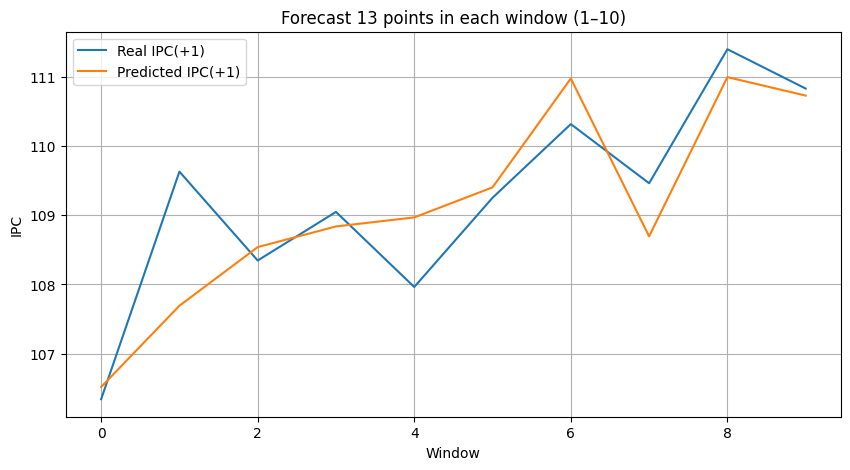

In [8]:

plt.figure(figsize=(10, 5))
plt.plot(true_vals, label="Real IPC(+1)")
plt.plot(pred_vals, label="Predicted IPC(+1)")
plt.title("Forecast 13 points in each window (1–10)")
plt.xlabel("Window")
plt.ylabel("IPC")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# === Full model (all data without windowing) ===

X_full = data.drop("IPC(+1)", axis=1).values
y_full = data["IPC(+1)"].values

scaler_x_full = MinMaxScaler()
scaler_y_full = MinMaxScaler()
X_full_scaled = scaler_x_full.fit_transform(X_full)
y_full_scaled = scaler_y_full.fit_transform(y_full.reshape(-1, 1)).flatten()

mlp_full = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', max_iter=1, warm_start=True)
mlp_full.fit(X_full_scaled, y_full_scaled)

n_weights = sum(w.size for w in mlp_full.coefs_ + mlp_full.intercepts_)
toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: random.uniform(-1.0, 1.0))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_weights)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_full(individual):
    start = 0
    i_weights = []
    for coef in mlp_full.coefs_ + mlp_full.intercepts_:
        shape = coef.shape
        size = np.prod(shape)
        new_weights = np.array(individual[start:start + size]).reshape(shape)
        i_weights.append(new_weights)
        start += size
    mlp_full.coefs_ = i_weights[:len(mlp_full.coefs_)]
    mlp_full.intercepts_ = i_weights[len(mlp_full.coefs_):]
    y_pred = mlp_full.predict(X_full_scaled)
    return (mean_squared_error(y_full_scaled, y_pred),)

toolbox.register("evaluate", eval_full)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=20)
hof = tools.HallOfFame(1)
algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=20, halloffame=hof, verbose=False)

# Assign the best weights
start = 0
i_weights = []
for coef in mlp_full.coefs_ + mlp_full.intercepts_:
    shape = coef.shape
    size = np.prod(shape)
    new_weights = np.array(hof[0][start:start + size]).reshape(shape)
    i_weights.append(new_weights)
    start += size

mlp_full.coefs_ = i_weights[:len(mlp_full.coefs_)]
mlp_full.intercepts_ = i_weights[len(mlp_full.coefs_):]

y_pred_full_scaled = mlp_full.predict(X_full_scaled)
y_pred_full = scaler_y_full.inverse_transform(y_pred_full_scaled.reshape(-1, 1)).flatten()
mse_full_model = mean_squared_error(y_full, y_pred_full)
print("MSE full model:", mse_full_model)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MSE full model: 2.5400015792177895


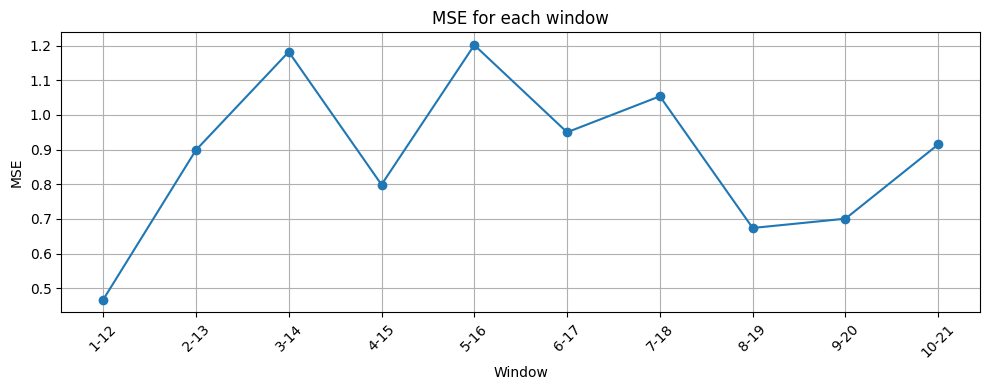

In [10]:
# === MSE graph by windows ===
plt.figure(figsize=(10, 4))
plt.plot(df_results["Window"], df_results["MSE"], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.grid(True)
plt.title("MSE for each window")
plt.xlabel("Window")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()